## Soft Q Learning through function approximation

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from env_simulator import ToyEnv

In [4]:
env = ToyEnv()

In [5]:
n_states = env.observation_space.shape[0]
n_actions = env.action_space.shape[0]
n_episodes = 2000
gamma = 0.98
tau = 0.0001
max_steps_per_ep = 100
learning_rate = 0.5

In [6]:
def softmax(x):
    num = np.exp(x - max(x))
    den = sum(num)
    return num/den

In [14]:
class QNetwork():

    def __init__(self, n_states, n_actions):
        self.n_states = n_states
        self.n_actions = n_actions
        self.inputs = tf.placeholder(tf.float32, [None, n_states])
        self.weights = tf.Variable(tf.random_uniform([n_states, n_actions],0,0.01))
        self.outputs = tf.matmul(self.inputs, self.weights)
        self.targets = tf.placeholder(tf.float32, [None, n_actions])

        self.loss = tf.losses.mean_squared_error(self.targets, self.outputs)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss)

    def choose_action(self, s, sess, tau, state_one_hot):
        q = sess.run(self.outputs, feed_dict={self.inputs:state_one_hot[s:s+1]})[0].T
        prob = softmax(np.clip(q1/tau,0,10))
        a = np.random.choice(self.n_actions,1,p=prob)
        return a[0], q

In [15]:
qnet = QNetwork(n_states, n_actions)
init = tf.global_variables_initializer()
state_one_hot = np.eye(n_states)
rewards = [] # To hold total reward per episode
avg_rewards = [] # To hold running average of rewards per episode

with tf.Session() as sess:
    sess.run(init)
    for ep in range(n_episodes):
        s,r,done = env.reset()
        n_step = 0
        ep_r = 0
        while not done:
            a,q = qnet.choose_action(s, sess, tau, state_one_hot)
            s1,r,done = env.step(a)
            q1 = sess.run(qnet.outputs, feed_dict={qnet.inputs:state_one_hot[s1:s1+1]})[0].T
            q[a] = r + gamma*tau*np.log((np.exp(np.clip(q1/tau,0,10))).sum())
            sess.run(qnet.optimizer, feed_dict={qnet.inputs:state_one_hot[s:s+1], qnet.targets:[q]})
            s = s1
            ep_r += r
            n_step += 1
            if n_step > max_steps_per_ep:
                break
        rewards.append(ep_r)
        avg_rewards.append(sum(rewards[-500:])/500.0)
        if not ep % 100:
            print("Episode #%d : Reward = %f, Avg Rew = %f" % (ep, ep_r, avg_rewards[-1]))    

Episode #0 : Reward = 1.000000, Avg Rew = 0.002000
Episode #100 : Reward = 1.000000, Avg Rew = 0.082000
Episode #200 : Reward = -1.000000, Avg Rew = 0.114000
Episode #300 : Reward = -1.000000, Avg Rew = 0.186000
Episode #400 : Reward = 1.000000, Avg Rew = 0.270000
Episode #500 : Reward = -1.000000, Avg Rew = 0.344000
Episode #600 : Reward = -1.000000, Avg Rew = 0.372000
Episode #700 : Reward = 1.000000, Avg Rew = 0.392000
Episode #800 : Reward = -1.000000, Avg Rew = 0.404000
Episode #900 : Reward = 1.000000, Avg Rew = 0.408000
Episode #1000 : Reward = 1.000000, Avg Rew = 0.436000
Episode #1100 : Reward = -1.000000, Avg Rew = 0.396000
Episode #1200 : Reward = -1.000000, Avg Rew = 0.420000
Episode #1300 : Reward = 1.000000, Avg Rew = 0.416000
Episode #1400 : Reward = 1.000000, Avg Rew = 0.412000
Episode #1500 : Reward = 1.000000, Avg Rew = 0.416000
Episode #1600 : Reward = 1.000000, Avg Rew = 0.412000
Episode #1700 : Reward = -1.000000, Avg Rew = 0.388000
Episode #1800 : Reward = 1.00000

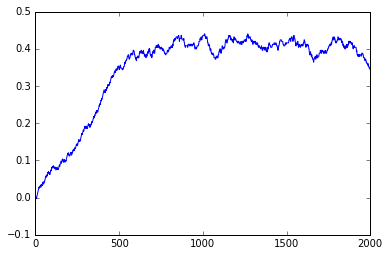

In [16]:
plt.plot(avg_rewards)